In [2]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import table
import seaborn as sns
from scipy import stats

import csv
import os
import re

!pip install spotipy
import spotipy  # library for interacting with spotify api
from spotipy.oauth2 import SpotifyClientCredentials  # handles oath sign in with spotify api credentials
import requests  # make http requests
from bs4 import BeautifulSoup  # read page content from when opening genius urls
import nltk  # nlp library
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # module for sentiment analysis
from nltk.corpus import stopwords  # used to remove common words like 'the, at, and' from lyrics

!pip install cloudmesh-common -U
from cloudmesh.common.Benchmark import Benchmark
from cloudmesh.common.StopWatch import StopWatch

nltk.download('vader_lexicon')
nltk.download('stopwords')

drive.mount('/content/drive')

notebook_location = "drive/MyDrive/BigDataProject"
data_directory = "drive/MyDrive/BigDataProject/data/"
data_files = ["tracks2020.csv","tracks2019.csv","tracks2018.csv","tracks2017.csv","alltracks.csv"]

  Using cached https://files.pythonhosted.org/packages/ba/a8/a01b2ef13709120a47311c17631d80acff89ac6afe01f4f0046ec70668c3/cloudmesh_common-4.3.26-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/73/96/1e6b19045375890068d7342cbe280dd64ae73fd90b9735b5efb8d1e044a1/simplejson-3.17.2-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/44/98/5b86278fbbf250d239ae0ecb724f8572af1c91f4a11edf4d36a206189440/colorama-0.4.4-py2.py3-none-any.whl
Processing /root/.cache/pip/wheels/0b/5b/55/ddcf52288f0b10f4564ca1b2531594ff7ccc65f487ba8dc437/python_hostlist-1.21-cp36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/37/aa/111610d8bf5b1bb7a295a048fc648cec346347a8b0be5881defd2d1b4a52/oyaml-1.0-py2.py3-none-any.whl
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


### **Spotify Api Tokens**

In [3]:
# API Tokens
clientID = 'XXXXXXXXXXXXXXXXXXXX'
clientSecret = 'XXXXXXXXXXXXXXXXXXXX'

credentialsManager = SpotifyClientCredentials(client_id=clientID, client_secret=clientSecret)
sp = spotipy.Spotify(client_credentials_manager=credentialsManager)

### **Get Tracks**

In [4]:
# receiving tracks data
track_results = sp.search(q='year:2020', type='track', limit=2, offset=0)

# example of a track 
print(track_results['tracks']['items'][0])

{'album': {'album_type': 'single', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6fWVd57NKTalqvmjRd2t8Z'}, 'href': 'https://api.spotify.com/v1/artists/6fWVd57NKTalqvmjRd2t8Z', 'id': '6fWVd57NKTalqvmjRd2t8Z', 'name': '24kGoldn', 'type': 'artist', 'uri': 'spotify:artist:6fWVd57NKTalqvmjRd2t8Z'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/6ASri4ePR7RlsvIQgWPJpS'}, 'href': 'https://api.spotify.com/v1/artists/6ASri4ePR7RlsvIQgWPJpS', 'id': '6ASri4ePR7RlsvIQgWPJpS', 'name': 'iann dior', 'type': 'artist', 'uri': 'spotify:artist:6ASri4ePR7RlsvIQgWPJpS'}], 'available_markets': ['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE', 'BG', 'BH', 'BO', 'BR', 'BY', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'KZ', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MD', 'ME', 'MK', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO

### **Creating The Dataset**

This is a snippet of how I created my data set, the full implementation can be found at ./code/get_music_data.py

**Note**: for some reason get_track_data is not returning the data on google colab but works in my python script


In [78]:
# search for a song on genius with song title and artist name, returns url to lyrics page for the song
genius_token = "XXXXXXXXXXXXXXXXXXXX"

def get_genius_url(title, artist):
    genius = 'https://api.genius.com/search'
    data = {'q': title + ' ' + artist}
    headers = {'Authorization': 'Bearer ' + genius_token}
    response = requests.get(genius, data=data, headers=headers)
    song_url = ''
    for hit in response.json()['response']['hits']:
        if artist == hit['result']['primary_artist']['name']:
            # print(title + '|' + artist)
            song_url = hit['result']['url']
            break
    return song_url


# parse lyrics page for lyrics, returns lyrics
def get_genius_lyrics_from_url(genius_url):
    lyrics = requests.get(genius_url)
    html = BeautifulSoup(lyrics.text, 'html.parser')
    genius_lyrics = html.find('div', class_='lyrics').get_text()
    return genius_lyrics


# cleans up song lyrics, removing empty lines, section headings, and any data that is not lyrical content
def lyrical_analysis(song_lyrics):
    lines = re.split(r'\n', song_lyrics)
    filtered = ""
    for line in lines:
        line = re.sub(r'[\(\[].*?[\)\]]|\n|\u2005|\u205f', '', line)
        filtered += line + '\n'
    cleaned_lyrics = os.linesep.join([line for line in filtered.splitlines() if line])
    sia = SentimentIntensityAnalyzer()

    # object to return with sentiment data
    senti_data = {}

    # count for lines that are mostly positive, mostly negative, or mostly neutral
    positive = 0
    negative = 0
    neutral = 0

    # iterate line by line through lyrics, read line scores, judge positivity and update the respective count
    for line in cleaned_lyrics.split('\n'):
        line_sentiment = sia.polarity_scores(line)
        score = line_sentiment['compound']
        if score >= 0.5:
            positive += 1
        elif score < -0.1:
            negative += 1
        else:
            neutral += 1

    # small calculations to populate senti_data
    total = positive + neutral + negative
    senti_data['num_positive'] = positive
    senti_data['num_negative'] = negative
    senti_data['num_neutral'] = neutral
    senti_data['positivity'] = positive / total
    senti_data['negativity'] = negative / total
    senti_data['neutrality'] = neutral / total
    return senti_data


# count the number of unique words from tokanized array
def count_unique_words(array_of_words):
    unique_words = []
    for word in array_of_words:
        if word not in unique_words:
            unique_words.append(word)
    return len(unique_words)


# remove common stopwords from lyrics, tokenize lyrics
def remove_stopwords(song_lyrics):
    lines = re.split(r'\n', song_lyrics)
    filtered = ""
    for line in lines:
        line = re.sub(r'[\(\[].*?[\)\]]|\n|\u2005|\u205f', ' ', line)
        filtered += line + 'n'
    lyrics_words = re.split(r',| |_|-|!', filtered)
    stops = stopwords.words('english')
    removed_stopwords = [word for word in lyrics_words if word not in stops and word != '']
    return removed_stopwords


def get_track_data(offset):
    count = offset
    # Dictionary to assign track IDs to the track names, for easy lookup
    tracks = {}

    # get top 50 songs in 2020
    track_results = sp.search(q='year:2020', type='track', limit=10, offset=offset)

    # populate tracks dictionary with track ids as keys, track names as values
    for i, t in enumerate(track_results['tracks']['items']):
        tracks[t['id']] = [t['name'], t['artists'][0]['name']]

    # get audio data for each track in tracks
    audio_data = sp.audio_features(tracks.keys())

    # get lyrical data from for each song
    for record in audio_data:
        try:
            print(tracks[record['id']][0] + " | " + tracks[record['id']][1])

            # store song name and artist name in audio_data
            record['name'] = tracks[record['id']][0]
            record['artist'] = tracks[record['id']][1]

            # fetch url to lyrics page for song
            url = get_genius_url(record['name'], record['artist'])

            # if url exists, perform lyrical analyses. add lyrical information to the audio data already contained in audio_data
            if url != '':
                lyrics = get_genius_lyrics_from_url(url)
                sentiment_data = lyrical_analysis(lyrics)
                record['num_positive'] = sentiment_data['num_positive']
                record['num_negative'] = sentiment_data['num_negative']
                record['num_neutral'] = sentiment_data['num_neutral']
                record['positivity'] = sentiment_data['positivity']
                record['negativity'] = sentiment_data['negativity']
                record['neutrality'] = sentiment_data['neutrality']
                lyrics = remove_stopwords(lyrics)
                record['word_count'] = len(lyrics)
                record['unique_word_count'] = count_unique_words(lyrics)
            else:
                record['word_count'] = 0
            count += 1
        except Exception as e:
            print("could not get lyrics for track")
    # return array of song data of songs that were successfully analyzed
    return [track for track in audio_data if (hasattr(track, 'word_count') and track['word_count'] != 0)]

In [53]:
StopWatch.start("Create dataset of 10 tracks")
get_track_data(0)
StopWatch.stop("Create dataset of 10 tracks")
StopWatch.status("Create dataset of 10 tracks", True)

Mood (feat. iann dior) | 24kGoldn
For The Night (feat. Lil Baby & DaBaby) | Pop Smoke
Dakiti | Bad Bunny
WAP (feat. Megan Thee Stallion) | Cardi B
Laugh Now Cry Later (feat. Lil Durk) | Drake
What You Know Bout Love | Pop Smoke
Therefore I Am | Billie Eilish
could not get lyrics for track
Lemonade | Internet Money
Holy (feat. Chance The Rapper) | Justin Bieber
ROCKSTAR (feat. Roddy Ricch) | DaBaby


#### **Sample Executions of NLTK Vader**

Briefly checking the usefullness of nltk vader module

In [54]:
sia = SentimentIntensityAnalyzer()

less_positive = sia.polarity_scores("I'm happy")
print("Scores for 'I'm happy':", less_positive)
positive = sia.polarity_scores("I'm so happy")
print("Scores for 'I'm so happy':",positive)
positive = sia.polarity_scores("I'm so happy!")
print("Scores for 'I'm so happy':",positive)

less_negative = sia.polarity_scores("I'm sad")
print("Scores for 'I'm sad':", less_negative)
negative = sia.polarity_scores("I'm so sad")
print("Scores for 'I'm so sad':",negative)
negative = sia.polarity_scores("I'm so sad!")
print("Scores for 'I'm so sad!':",negative)

gibberish = sia.polarity_scores("ksaf asdko fgaodjg asopg")
print("Scores for gibberish text:", gibberish)
spanish = sia.polarity_scores("Qué feliz estoy")
print("Scores for spanish text:", spanish)

Scores for 'I'm happy': {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
Scores for 'I'm so happy': {'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}
Scores for 'I'm so happy': {'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}
Scores for 'I'm sad': {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
Scores for 'I'm so sad': {'neg': 0.629, 'neu': 0.371, 'pos': 0.0, 'compound': -0.5256}
Scores for 'I'm so sad!': {'neg': 0.648, 'neu': 0.352, 'pos': 0.0, 'compound': -0.5697}
Scores for gibberish text: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Scores for spanish text: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


**Benchmark: Sentiment analysis on an example line of text**

In [55]:
StopWatch.start("Sentiment Intensity Analyzer on a line of lyrical text")
lyrical_line = sia.polarity_scores("Make it feel like a movie you saw in your youth")
print("SIA Scores:", less_positive)
StopWatch.stop("Sentiment Intensity Analyzer on a line of lyrical text")
StopWatch.status("Sentiment Intensity Analyzer on a line of lyrical text",True)

SIA Scores: {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}


### **Data Examples**

In [56]:
# Sample data visualization - 2020 tracks
df_2020 = pd.read_csv(data_directory + data_files[0], encoding='windows-1252')
pd.set_option('display.width', None)
print(df_2020)

      danceability  energy  key  ...  neutrality  word_count  unique_word_count
0            0.709   0.548   10  ...    0.785714         209                130
1            0.799   0.660    1  ...    0.596491         307                177
2            0.514   0.730    1  ...    0.628571         150                 75
3            0.650   0.613    9  ...    0.576923         238                104
4            0.737   0.802    0  ...    0.687500         178                 73
...            ...     ...  ...  ...         ...         ...                ...
1499         0.561   0.810    8  ...    0.526316         183                 93
1500         0.840   0.304    0  ...    0.769231         163                 68
1501         0.620   0.817   11  ...    0.976744         126                 81
1502         0.429   0.399    5  ...    0.595745         154                 70
1503         0.652   0.595   11  ...    0.947368         246                107

[1504 rows x 28 columns]


In [57]:
# get averages for 2020 tracks
avgs_2020 = df_2020.mean(axis=0)
# headers = ['danceability', 'energy', 'acousticness', 'loudness', 'instrumentalness', 'speechiness', 'valence', 'tempo', 'word_count', 'positivity', 'negativity', 'neutrality']
print(avgs_2020)


danceability              0.694340
energy                    0.644976
key                       5.413564
loudness                 -6.273446
mode                      0.551862
speechiness               0.138697
acousticness              0.229685
instrumentalness          0.008165
liveness                  0.179198
valence                   0.529568
tempo                   123.259806
duration_ms          192180.333112
time_signature            3.935505
num_positive              3.821144
num_negative             12.091755
num_neutral              39.965426
positivity                0.077459
negativity                0.218712
neutrality                0.703829
word_count              258.378324
unique_word_count       130.437500
dtype: float64


### **Averages for each Year**

In [58]:
df_2019 = pd.read_csv(data_directory + data_files[1], encoding='windows-1252')

df_2018 = pd.read_csv(data_directory + data_files[2], encoding='windows-1252')

df_2017 = pd.read_csv(data_directory + data_files[3], encoding='windows-1252')


avgs_2019 = df_2019.mean(axis=0)
avgs_2018 = df_2018.mean(axis=0)
avgs_2017 = df_2017.mean(axis=0)
print("**2020 Averages**\n")
print(avgs_2020)
print("\n**2019 Averages**\n")
print(avgs_2019)
print("\n**2018 Averages**\n")
print(avgs_2018)
print("\n**2017 Averages**\n")
print(avgs_2017)

**2020 Averages**

danceability              0.694340
energy                    0.644976
key                       5.413564
loudness                 -6.273446
mode                      0.551862
speechiness               0.138697
acousticness              0.229685
instrumentalness          0.008165
liveness                  0.179198
valence                   0.529568
tempo                   123.259806
duration_ms          192180.333112
time_signature            3.935505
num_positive              3.821144
num_negative             12.091755
num_neutral              39.965426
positivity                0.077459
negativity                0.218712
neutrality                0.703829
word_count              258.378324
unique_word_count       130.437500
dtype: float64

**2019 Averages**

danceability              0.668863
energy                    0.602985
key                       5.133603
loudness                 -6.787258
mode                      0.625506
speechiness               0.127243
a

### **Simple Analysis on Complete Dataset**

In [59]:
# print all records
StopWatch.start("Load dataset")
df_all = pd.read_csv(data_directory + data_files[4], encoding='windows-1252')
print(df_all)
StopWatch.stop("Load dataset")
StopWatch.status("Load dataset", True)

# averages of data from tracks in 2017-2020
StopWatch.start("Calculate averages of values in dataset")
avgs_all = df_all.mean(axis=0)
print(avgs_all)
StopWatch.stop("Calculate averages of values in dataset")
StopWatch.status("Calculate averages of values in dataset", True)

      danceability  energy  key  ...  neutrality  word_count  unique_word_count\r
0            0.872   0.391    0  ...    0.483871         135                   95
1            0.773   0.750    8  ...    0.867470         429                  175
2            0.732   0.750   11  ...    0.742857         240                  151
3            0.734   0.570    7  ...    0.418605         213                   66
4            0.776   0.503    0  ...    0.765625         253                  165
...            ...     ...  ...  ...         ...         ...                  ...
6046         0.561   0.810    8  ...    0.526316         183                   93
6047         0.840   0.304    0  ...    0.769231         163                   68
6048         0.620   0.817   11  ...    0.976744         126                   81
6049         0.429   0.399    5  ...    0.595745         154                   70
6050         0.652   0.595   11  ...    0.947368         246                  107

[6051 rows x 28

#### **Heatmap of all track data**

      valence  energy  danceability  positivity  negativity
0       0.437   0.391         0.872    0.032258    0.483871
1       0.783   0.750         0.773    0.048193    0.084337
2       0.401   0.750         0.732    0.014286    0.242857
3       0.689   0.570         0.734    0.000000    0.581395
4       0.473   0.503         0.776    0.078125    0.156250
...       ...     ...           ...         ...         ...
6046    0.508   0.810         0.561    0.052632    0.421053
6047    0.656   0.304         0.840    0.128205    0.102564
6048    0.614   0.817         0.620    0.023256    0.000000
6049    0.353   0.399         0.429    0.297872    0.106383
6050    0.444   0.595         0.652    0.000000    0.052632

[6051 rows x 5 columns]


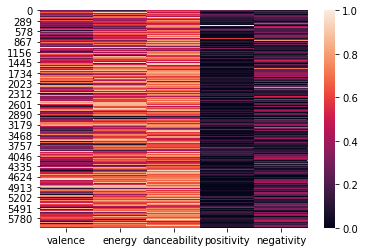

In [60]:
StopWatch.start("Generate and display heatmap of data")
heatmap_df = pd.DataFrame(df_all,columns=['valence','energy','danceability','positivity','negativity'])
print(heatmap_df)
sns.heatmap(heatmap_df)
StopWatch.stop("Generate and display heatmap of data")
StopWatch.status("Generate and display heatmap of data", True)

#### **Scatterplots**

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


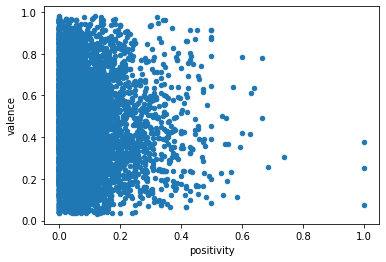

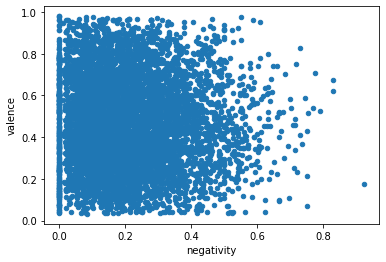

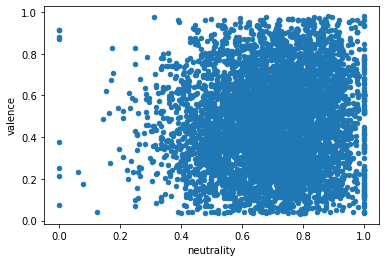

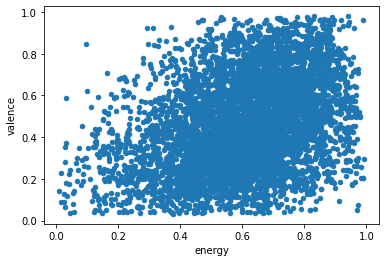

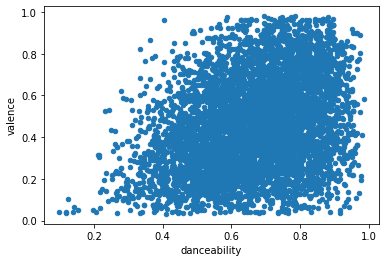

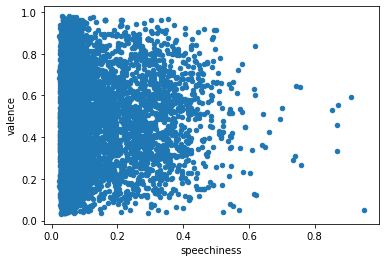

In [61]:
scatterplot_df = pd.DataFrame(df_all,columns=['valence','positivity', 'negativity', 'neutrality', 'energy', 'danceability','speechiness'])
scatterplot = scatterplot_df.plot.scatter(x='positivity', y='valence');
print(scatterplot)
scatterplot = scatterplot_df.plot.scatter(x='negativity', y='valence');
print(scatterplot)
scatterplot = scatterplot_df.plot.scatter(x='neutrality', y='valence');
print(scatterplot)
scatterplot = scatterplot_df.plot.scatter(x='energy', y='valence');
print(scatterplot)
scatterplot = scatterplot_df.plot.scatter(x='danceability', y='valence');
print(scatterplot)
scatterplot = scatterplot_df.plot.scatter(x='speechiness', y='valence');
print(scatterplot)

#### **Linear Regression**

In [62]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(scatterplot_df['positivity'], scatterplot_df['valence'])
print("Positivity: " + str(rvalue))

slope, intercept, rvalue, pvalue, stderr = stats.linregress(scatterplot_df['negativity'], scatterplot_df['valence'])
print("Negativity: " + str(rvalue))

slope, intercept, rvalue, pvalue, stderr = stats.linregress(scatterplot_df['neutrality'], scatterplot_df['valence'])
print("Neutrality: " + str(rvalue))

slope, intercept, rvalue, pvalue, stderr = stats.linregress(scatterplot_df['energy'], scatterplot_df['valence'])
print("Energy: " +  str(rvalue))

slope, intercept, rvalue, pvalue, stderr = stats.linregress(scatterplot_df['danceability'], scatterplot_df['valence'])
print("Danceability: " + str(rvalue))

slope, intercept, rvalue, pvalue, stderr = stats.linregress(scatterplot_df['speechiness'], scatterplot_df['valence'])
print("Speechiness: " + str(rvalue))

Positivity: -0.09085904719239368
Negativity: -0.03968682775757214
Neutrality: 0.09300278327796202
Energy: 0.3671136114556208
Danceability: 0.3244126621463708
Speechiness: 0.0664928556518328


#### **Polynomial Regression**

In [63]:
from sklearn.metrics import r2_score

positivity = np.poly1d(np.polyfit(scatterplot_df['positivity'], scatterplot_df['valence'], 3))
print("Positivity: " + str(r2_score(scatterplot_df['valence'], positivity(scatterplot_df['positivity']))))

negativity = np.poly1d(np.polyfit(scatterplot_df['negativity'], scatterplot_df['valence'], 3))
print("Negativity: " + str(r2_score(scatterplot_df['valence'], negativity(scatterplot_df['negativity']))))

neutrality = np.poly1d(np.polyfit(scatterplot_df['neutrality'], scatterplot_df['valence'], 3))
print("Neutrality: " + str(r2_score(scatterplot_df['valence'], neutrality(scatterplot_df['neutrality']))))

energy = np.poly1d(np.polyfit(scatterplot_df['energy'], scatterplot_df['valence'], 3))
print("Energy: " + str(r2_score(scatterplot_df['valence'], energy(scatterplot_df['energy']))))

danceability = np.poly1d(np.polyfit(scatterplot_df['danceability'], scatterplot_df['valence'], 3))
print("Danceability: " + str(r2_score(scatterplot_df['valence'], danceability(scatterplot_df['danceability']))))

speechiness = np.poly1d(np.polyfit(scatterplot_df['speechiness'], scatterplot_df['valence'], 3))
print("Speechiness: " + str(r2_score(scatterplot_df['valence'], speechiness(scatterplot_df['speechiness']))))


Positivity: 0.013164307063551983
Negativity: 0.0015881836927739146
Neutrality: 0.010308495205133328
Energy: 0.13682211334373118
Danceability: 0.11311954500785304
Speechiness: 0.008913924659264771


#### **Multiple Regression**

In [64]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

X = df_all[['neutrality','energy', 'danceability', 'speechiness']]
y = df_all['valence']

regr = linear_model.LinearRegression()
regr.fit(X, y)
print(regr.coef_)

predictedValence = regr.predict([[0.5, 0.8, 0.66, 0.1]])
print(predictedValence)

[ 0.13161981  0.42176618  0.46991293 -0.02300469]
[0.52416698]


In [65]:
df_all_lr = df_all.dropna(axis=0)
train = df_all_lr[0:5500]
test = df_all_lr[5500::]
print("Size of training set: " + str(len(train)))
print("Size of testing set: " + str(len(test)))

Size of training set: 5500
Size of testing set: 551


**Fit Training Model**

In [66]:
lr = linear_model.LinearRegression()
X_train = scale.fit_transform(train[['positivity','energy', 'danceability']])
y_train = train['valence']

lr.fit(X_train,y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Create test dataset**

In [67]:
X_test = scale.fit_transform(test[['positivity','energy', 'danceability']])
y_test = test['valence']

**Predictions and calculate Mean Squared Error and Relative Mean Squared Error**

In [68]:
valence_predictions = lr.predict(X_test) 
mse = np.mean((y_test - valence_predictions)**2)
rmse = np.sqrt(mse)
print("Mean Squared Error: " + str(mse))
print("Relative Mean Squared Error: " + str(rmse))

Mean Squared Error: 0.039285234472273396
Relative Mean Squared Error: 0.19820503139999598


**Plot Differences between expected and prediction results**

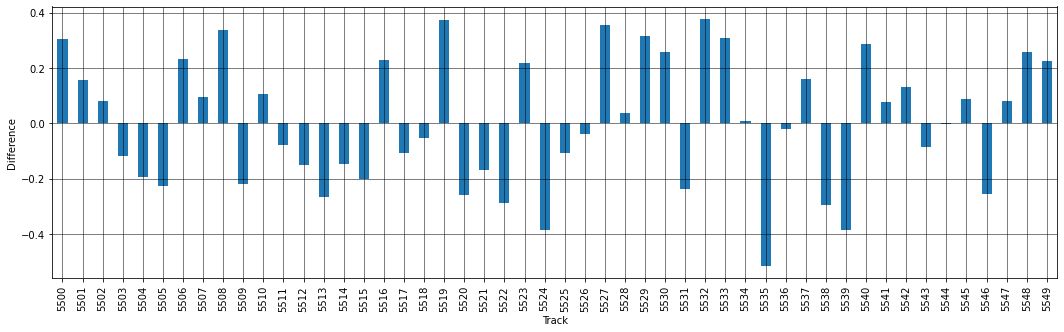

In [69]:
df = pd.DataFrame({'expected': y_test, 'predicted': valence_predictions})
df_50 = df.head(50)
 
error = df_50['expected'] - df_50['predicted']

error.plot(kind='bar',figsize=(18,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('Track')
plt.ylabel('Difference')
plt.xticks(rotation=90)
plt.show()

#### **Multiple Regresssion with all captured numerical data fields**

In [75]:
StopWatch.start("Multivariate Regression Analysis on dataset")
df_all_data = df_all.dropna(axis = 0)
train = df_all_lr[0:5500]
test = df_all_lr[5500::]

X_train = scale.fit_transform(train[['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','tempo','positivity','neutrality','word_count','unique_word_count\r']])
y_train = train['valence']
lr.fit(X_train,y_train) 

X_test = scale.fit_transform(test[['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','tempo','positivity','neutrality','word_count','unique_word_count\r']])
y_test = test['valence']

valence_predictions = lr.predict(X_test) 
mse = np.mean((y_test - valence_predictions)**2)
rmse = np.sqrt(mse)
StopWatch.stop("Multivariate Regression Analysis on dataset")
StopWatch.status("Multivariate Regression Analysis on dataset", True)
print("Mean Squared Error: " + str(mse))
print("Relative Mean Squared Error: " + str(rmse))

Mean Squared Error: 0.036297028743586535
Relative Mean Squared Error: 0.19051779114714334


**Error Plot**

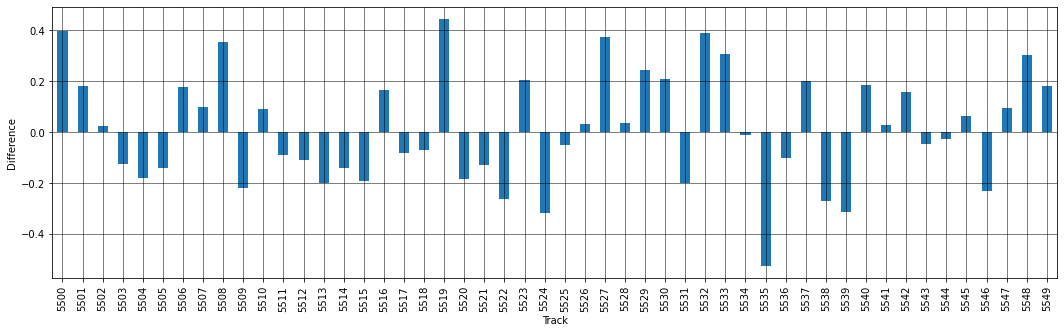

In [76]:
# show difference between expected and predicted values
StopWatch.start("Plot differences")
df = pd.DataFrame({'expected': y_test, 'predicted': valence_predictions})
df_50 = df.head(50)
 
error = df_50['expected'] - df_50['predicted']

error.plot(kind='bar',figsize=(18,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('Track')
plt.ylabel('Difference')
plt.xticks(rotation=90)
plt.show()
StopWatch.stop("Plot differences")
StopWatch.status("Plot differences", True)

### **Benchmark**

In [77]:
StopWatch.benchmark()


+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | bionic                                                           |
| DISTRIB_DESCRIPTION | "Ubuntu 18.04.5 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 18.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           